In [1]:
# =============================================================================
# Fragment 1: Import Libraries and Define Global Constants
# =============================================================================
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from glob import glob
from skimage import exposure, measure, feature

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn

import albumentations as A
from albumentations.pytorch import ToTensorV2

import warnings
warnings.filterwarnings('ignore')

# Define directories for data and model weights
WEIGHTS_DIR = './'
DIR_TRAIN = os.path.join("dataset/images_dicom")
CSV_FILE = "processed_finding_annotations_updated.csv"


In [2]:
# =============================================================================
# Fragment 2: Load and Inspect Annotation Data
# =============================================================================
dataset = pd.read_csv(CSV_FILE)
print("Dataset head:")
print(dataset.head())


Dataset head:
                                processed_image_path  \
0  dataset/images_preprocessed/4e3a578fe535ea4f52...   
1  dataset/images_preprocessed/dac39351b0f3a8c670...   
2  dataset/images_preprocessed/c83f780904f25eacb4...   
3  dataset/images_preprocessed/893528bc38a0362928...   
4  dataset/images_preprocessed/318264c881bf12f2c1...   

                           study_id                         series_id  \
0  48575a27b7c992427041a82fa750d3fa  26de4993fa6b8ae50a91c8baf49b92b0   
1  48575a27b7c992427041a82fa750d3fa  26de4993fa6b8ae50a91c8baf49b92b0   
2  75e8e48933289d70b407379a564f8594  853b70e7e6f39133497909d9ca4c756d   
3  75e8e48933289d70b407379a564f8594  853b70e7e6f39133497909d9ca4c756d   
4  c3487424fee1bdd4515b72dc3fd69813  77619c914263eae44e9099f1ce07192c   

                           image_id laterality view_position breast_birads  \
0  4e3a578fe535ea4f5258d3f7f4419db8          R            CC     BI-RADS 4   
1  dac39351b0f3a8c670b7f8dc88029364          R        

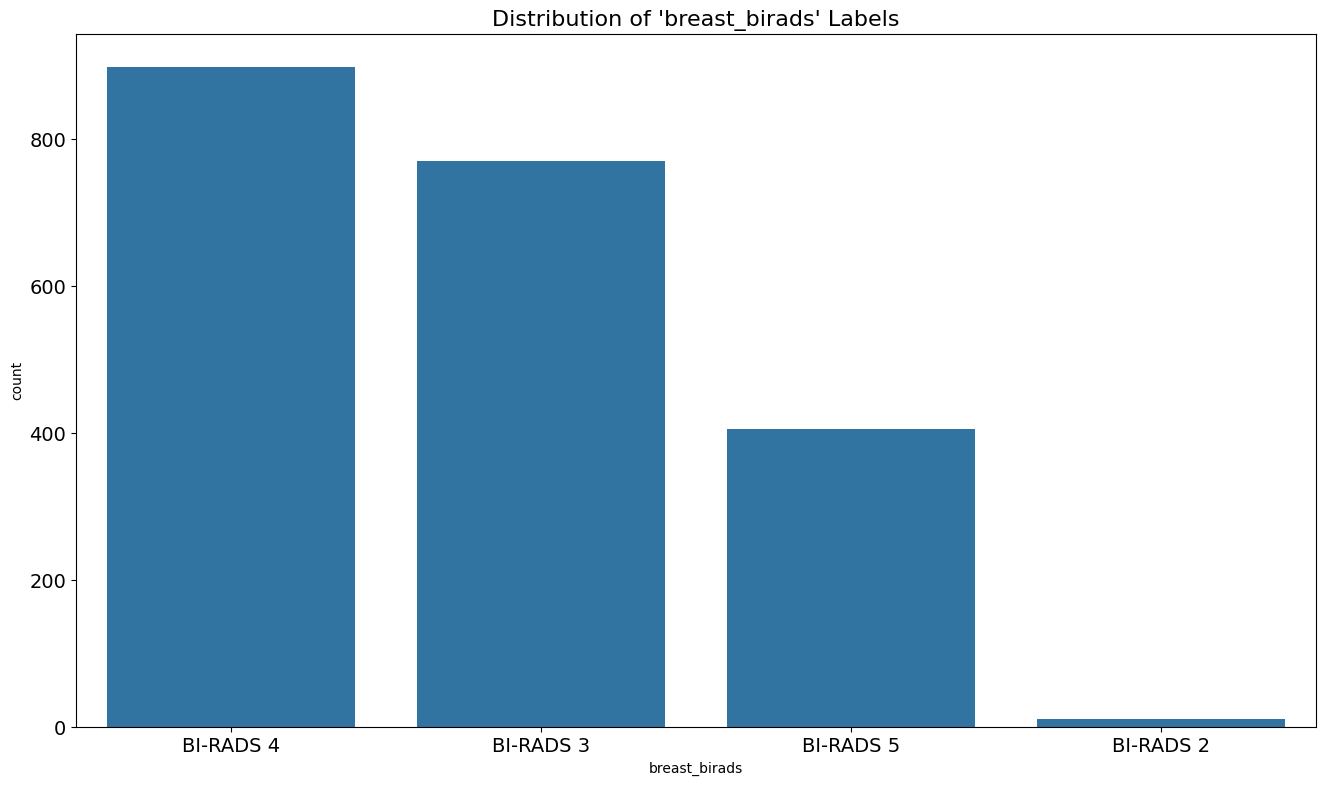

In [3]:
# =============================================================================
# Fragment 3: Visualize the Distribution of 'breast_birads' Labels
# =============================================================================
plt.figure(figsize=(16, 9))
sns.countplot(x='breast_birads', data=dataset)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14)
plt.title("Distribution of 'breast_birads' Labels", fontsize=16)
plt.show()


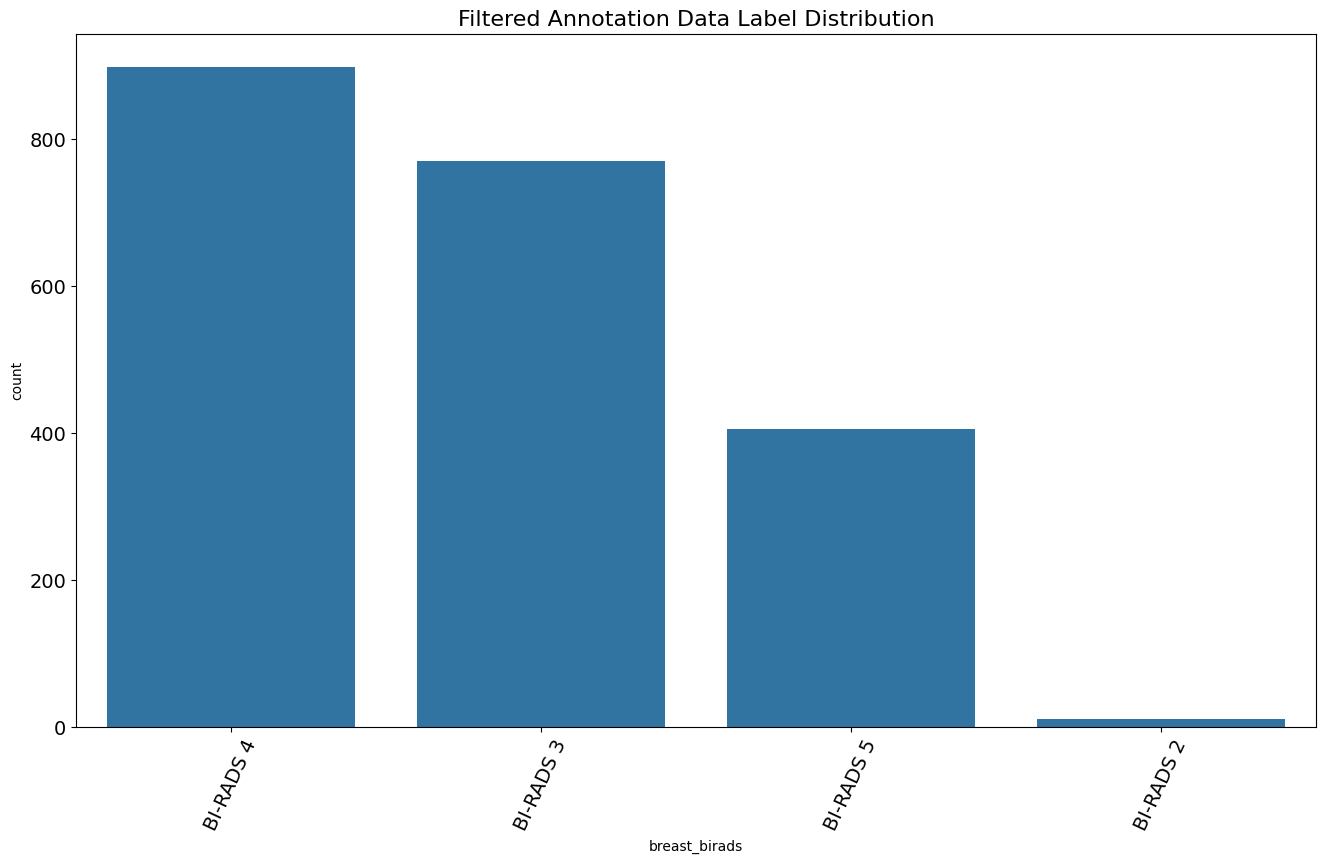

In [4]:
# =============================================================================
# Fragment 4: Preprocess the Dataset – Filter Rows with Valid Bounding Boxes
# =============================================================================
dataset_filtered = dataset[
    (dataset['xmin_c'] > 0) & (dataset['ymin_c'] > 0) &
    (dataset['xmax_c'] > 0) & (dataset['ymax_c'] > 0)
].reset_index(drop=True)

dataset_new = dataset_filtered.dropna(subset=['xmin_c', 'ymin_c', 'xmax_c', 'ymax_c'])
dataset_new = dataset_new[
    (dataset_new['xmin_c'] > 0) & (dataset_new['ymin_c'] > 0) &
    (dataset_new['xmax_c'] > dataset_new['xmin_c']) & (dataset_new['ymax_c'] > dataset_new['ymin_c'])
].reset_index(drop=True)

plt.figure(figsize=(16, 9))
sns.countplot(x='breast_birads', data=dataset_new)
plt.xticks(fontsize=14, rotation=65)
plt.yticks(fontsize=14)
plt.title("Filtered Annotation Data Label Distribution", fontsize=16)
plt.show()


In [5]:
# =============================================================================
# Fragment 5: Split the Dataset into Training and Validation Sets
# =============================================================================
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(dataset_new, test_size=0.15, random_state=42)
print("Training set size:", len(train_df))
print("Validation set size:", len(valid_df))


Training set size: 1769
Validation set size: 313


In [14]:
# =============================================================================
# Fragment 6: Define the Custom Dataset Class with Additional Feature Calculation
# =============================================================================
class LungsAnnotationDataset(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None):
        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def calculate_features(self, region):
        # Return zero features if region is too small
        if region.size < 2:
            return {
                'eccentricity': 0,
                'mean_intensity': 0,
                'std_intensity': 0,
                'entropy': 0,
                'contrast': 0,
                'correlation': 0,
                'energy': 0,
                'homogeneity': 0,
            }
        # Compute region properties and texture features
        props = measure.regionprops(region.astype(int))
        eccentricity = props[0].eccentricity if props else 0
        mean_intensity = np.mean(region)
        std_intensity = np.std(region)
        entropy = measure.shannon_entropy(region)
        glcm = feature.graycomatrix(region.astype(np.uint8), [1], [0], symmetric=True, normed=True)
        contrast = feature.graycoprops(glcm, 'contrast')[0, 0]
        correlation = feature.graycoprops(glcm, 'correlation')[0, 0]
        energy = feature.graycoprops(glcm, 'energy')[0, 0]
        homogeneity = feature.graycoprops(glcm, 'homogeneity')[0, 0]
        return {
            'eccentricity': eccentricity,
            'mean_intensity': mean_intensity,
            'std_intensity': std_intensity,
            'entropy': entropy,
            'contrast': contrast,
            'correlation': correlation,
            'energy': energy,
            'homogeneity': homogeneity,
        }
    
    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]
        if len(records) == 0:
            return None

        # Read the DICOM file and apply VOI LUT
        dcm_path = os.path.join(self.image_dir, f'{image_id}.dicom')
        dcm_data = pydicom.dcmread(dcm_path)
        image = apply_voi_lut(dcm_data.pixel_array, dcm_data)
        # Invert image if PhotometricInterpretation is MONOCHROME1
        if dcm_data.PhotometricInterpretation == "MONOCHROME1":
            image = np.amax(image) - image
        image = image.astype(float)
        image /= image.max()  # Normalize pixel values to [0, 1]
        image = exposure.equalize_hist(image)
        image = image.astype('float32')

        # Prepare bounding boxes and labels for cancer and breast regions
        cancer_boxes = records[['xmin_c', 'ymin_c', 'xmax_c', 'ymax_c']].values
        breast_boxes = records[['xmin_b', 'ymin_b', 'xmax_b', 'ymax_b']].values
        cancer_labels = records['breast_birads_id'].values  # Cancer labels
        breast_labels = np.zeros(len(breast_boxes), dtype=int)  # Breast region labels set to 0

        # Calculate additional features for each breast region
        breast_features = []
        for box in breast_boxes:
            x_min, y_min, x_max, y_max = map(int, box)
            breast_region = image[y_min:y_max, x_min:x_max]
            features = self.calculate_features(breast_region)
            breast_features.append(features)
        
        # Apply transformations (e.g., resizing, conversion to tensor)
        if self.transforms:
            transformed = self.transforms(
                image=image,
                bboxes=np.vstack((cancer_boxes, breast_boxes)),
                labels=np.concatenate((cancer_labels, breast_labels))
            )
            image = transformed['image']
            all_boxes = transformed['bboxes']
            all_labels = transformed['labels']
            # Split the transformed boxes and labels back to cancer and breast regions
            cancer_boxes = all_boxes[:len(cancer_boxes)]
            breast_boxes = all_boxes[len(cancer_boxes):]
            cancer_labels = all_labels[:len(cancer_labels)]
            breast_labels = all_labels[len(cancer_labels):]
        
        # Convert boxes and labels to tensors
        cancer_boxes = torch.as_tensor(cancer_boxes, dtype=torch.float32)
        breast_boxes = torch.as_tensor(breast_boxes, dtype=torch.float32)
        cancer_labels = torch.as_tensor(cancer_labels, dtype=torch.long)
        
        # Convert the list of feature dictionaries to a tensor
        # Feature order: eccentricity, mean_intensity, std_intensity, entropy, contrast, correlation, energy, homogeneity
        breast_features_tensor = torch.as_tensor([list(f.values()) for f in breast_features], dtype=torch.float32)
        
        target = {
            'boxes': cancer_boxes,
            'labels': cancer_labels,
            'breast_boxes': breast_boxes,
            'breast_features': breast_features_tensor  # Additional features for auxiliary branch
        }
        return image, target

    def __len__(self):
        return len(self.image_ids)


In [15]:
# =============================================================================
# Fragment 7: Define Data Transformations for Training and Validation
# =============================================================================
def get_train_transform():
    return A.Compose([
        A.Resize(500, 500),  # Resize image to 1500x1500
        ToTensorV2()          # Convert image to a PyTorch tensor
    ], bbox_params=A.BboxParams(
        format='pascal_voc',  # Bounding box format: x_min, y_min, x_max, y_max
        label_fields=['labels']
    ))

def get_valid_transform():
    return A.Compose([
        A.Resize(500, 500),  # Resize image to 1500x1500
        ToTensorV2()
    ], bbox_params=A.BboxParams(
        format='pascal_voc',
        label_fields=['labels']
    ))


In [16]:
# =============================================================================
# Fragment 8: Create Dataset Objects and DataLoaders
# =============================================================================
train_dataset = LungsAnnotationDataset(
    dataframe=train_df,
    image_dir=DIR_TRAIN,
    transforms=get_train_transform()
)

valid_dataset = LungsAnnotationDataset(
    dataframe=valid_df,
    image_dir=DIR_TRAIN,
    transforms=get_valid_transform()
)

def collate_fn(batch):
    # Remove items that are None or have no bounding boxes
    batch = [b for b in batch if b is not None and b[1]['boxes'].shape[0] > 0]
    if not batch:
        return torch.tensor([]), {}
    return tuple(zip(*batch))

train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)


In [10]:
# =============================================================================
# Fragment 9: Set Up the Device (CPU or GPU)
# =============================================================================
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


In [17]:
# =============================================================================
# Fragment 10: Define the Modified Faster R-CNN Model with Auxiliary Branch
# =============================================================================
class ModifiedFasterRCNN(torchvision.models.detection.FasterRCNN):
    def __init__(self, num_classes, breast_feature_size):
        # Initialize with a backbone from a pre-trained Faster R-CNN model
        backbone = fasterrcnn_resnet50_fpn(pretrained=True).backbone
        super(ModifiedFasterRCNN, self).__init__(backbone, num_classes)
        
        # Load a pre-trained model to obtain the number of input features for the classifier
        model_pretrained = fasterrcnn_resnet50_fpn(pretrained=True)
        in_features = model_pretrained.roi_heads.box_predictor.cls_score.in_features
        # Replace the head with a new predictor for our number of classes
        model_pretrained.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        self.roi_heads = model_pretrained.roi_heads
        
        # New linear layer for processing additional breast features (8-dimensional vector)
        self.breast_feature_fc = nn.Linear(breast_feature_size, in_features)
        
        # Auxiliary classifier for binary classification:
        # 0 - no cancer present, 1 - cancer present
        self.aux_classifier = nn.Linear(in_features, 2)

    def forward(self, images, targets=None):
        if targets is not None:
            aux_loss_total = 0.0
            aux_loss_fn = nn.CrossEntropyLoss()
            # Process additional breast features for each image in the batch
            for t in targets:
                # 'breast_features' is of shape (N, 8) where N is the number of breast regions
                breast_features = t['breast_features']
                processed_features = self.breast_feature_fc(breast_features)  # (N, in_features)
                aggregated_features = processed_features.mean(dim=0, keepdim=True)  # (1, in_features)
                aux_logits = self.aux_classifier(aggregated_features)  # (1, 2)
                # Set target: if there is at least one cancer box then label = 1, otherwise 0
                cancer_present = 1 if t['boxes'].shape[0] > 0 else 0
                t['aux_target'] = torch.tensor([cancer_present], dtype=torch.long, device=aux_logits.device)
                t['aux_logits'] = aux_logits
                aux_loss_total += aux_loss_fn(aux_logits, t['aux_target'])
            aux_loss_total = aux_loss_total / len(targets)
            
            # Use the additional features in both training and validation when targets are provided
            if self.training:
                losses = super(ModifiedFasterRCNN, self).forward(images, targets)
                losses['loss_aux'] = aux_loss_total
                return losses
            else:
                # In evaluation mode with annotations, return detections along with auxiliary logits
                outputs = super(ModifiedFasterRCNN, self).forward(images, targets)
                # Append auxiliary logits to each detection (for analysis)
                for i in range(len(outputs)):
                    outputs[i]['aux_logits'] = targets[i]['aux_logits']
                # Also append the auxiliary loss for reporting purposes
                outputs.append({'loss_aux': aux_loss_total})
                return outputs
        else:
            # In inference mode when no targets are provided
            outputs = super(ModifiedFasterRCNN, self).forward(images, targets)
            return outputs

# Define the number of classes (for example: 4 cancer classes + 1 normal class)
num_classes = 5
breast_feature_size = 8

# Create the modified model and move it to the selected device
model = ModifiedFasterRCNN(num_classes=num_classes, breast_feature_size=breast_feature_size)
model.to(device)


ModifiedFasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu

In [18]:
# =============================================================================
# Fragment 11: Set Up the Optimizer
# =============================================================================
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.0005, momentum=0.9, weight_decay=0.0005)


In [19]:
# =============================================================================
# Fragment 12: Training Loop with Per-Iteration Logging and CSV Save
# =============================================================================
import pandas as pd
from tqdm import tqdm

num_epochs = 50
# List to store training metrics for every iteration
training_history = []
global_iteration = 0  # Counter for all iterations across epochs

for epoch in range(num_epochs):
    model.train()
    total_loss_epoch = 0.0
    total_batches = 0
    
    # Create a progress bar for the current epoch
    progress_bar = tqdm(train_data_loader, desc=f"Epoch {epoch+1}", unit="batch")
    for iter_idx, (images, targets) in enumerate(progress_bar, start=1):
        global_iteration += 1
        optimizer.zero_grad()
        
        # Move images to the device (GPU or CPU)
        images = [img.to(device) for img in images]
        # Move target tensors to the device
        for t in targets:
            for key, value in t.items():
                if isinstance(value, torch.Tensor):
                    t[key] = value.to(device)
                    
        # Forward pass to obtain losses
        loss_dict = model(images, targets)
        
        # Extract individual loss components (default to 0.0 if missing)
        loss_classifier = loss_dict.get("loss_classifier", torch.tensor(0.0, device=device))
        loss_box_reg = loss_dict.get("loss_box_reg", torch.tensor(0.0, device=device))
        loss_objectness = loss_dict.get("loss_objectness", torch.tensor(0.0, device=device))
        loss_rpn_box_reg = loss_dict.get("loss_rpn_box_reg", torch.tensor(0.0, device=device))
        loss_aux = loss_dict.get("loss_aux", torch.tensor(0.0, device=device))
        
        # Total loss is the sum of all components
        loss = loss_classifier + loss_box_reg + loss_objectness + loss_rpn_box_reg + loss_aux
        loss.backward()
        optimizer.step()
        
        # Accumulate loss for averaging over the epoch
        total_loss_epoch += loss.item()
        total_batches += 1
        
        # Log metrics for the current iteration
        iteration_metrics = {
            "Epoch": epoch + 1,
            "Iteration": iter_idx,          # Iteration number within the current epoch
            "Global Iteration": global_iteration,  # Overall iteration number across epochs
            "Loss": loss.item(),
            "Loss Classifier": loss_classifier.item(),
            "Loss Box Reg": loss_box_reg.item(),
            "Loss Objectness": loss_objectness.item(),
            "Loss RPN Box Reg": loss_rpn_box_reg.item()
        }
        training_history.append(iteration_metrics)
        
        # Update the progress bar display with current batch loss metrics
        progress_bar.set_postfix({
            "Loss": f"{loss.item():.4f}",
            "Loss Classifier": f"{loss_classifier.item():.4f}",
            "Loss Box Reg": f"{loss_box_reg.item():.4f}",
            "Loss Objectness": f"{loss_objectness.item():.4f}",
            "Loss RPN Box Reg": f"{loss_rpn_box_reg.item():.4f}"
        })
    
    # Calculate and display the average loss for the epoch
    avg_loss = total_loss_epoch / total_batches if total_batches > 0 else 0
    print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {avg_loss:.4f}")
    
    # Optionally, save the model checkpoint after each epoch
    torch.save(model.state_dict(), f"modified_fasterrcnn_epoch_{epoch+1}.pth")

# Convert the training history list to a DataFrame and save it to a CSV file
history_df = pd.DataFrame(training_history)
history_df.to_csv("training_history_per_iteration.csv", index=False)
print("Training history saved to 'training_history_per_iteration.csv'")


Epoch 1:  25%|██▍       | 88/357 [14:29<49:20, 11.01s/batch, Loss=0.3129, Loss Classifier=0.0757, Loss Box Reg=0.0527, Loss Objectness=0.1389, Loss RPN Box Reg=0.0456]

In [ ]:
# =============================================================================
# Fragment 13: Validation Loop Using Additional Features with Annotations
# =============================================================================
model.eval()
with torch.no_grad():
    for images, targets in valid_data_loader:
        # Move images and targets to the device
        images = [img.to(device) for img in images]
        for t in targets:
            for key, value in t.items():
                if isinstance(value, torch.Tensor):
                    t[key] = value.to(device)
        # Forward pass in evaluation mode with targets provided
        outputs = model(images, targets)
        # 'outputs' is a list of detections for each image plus an extra dictionary for auxiliary loss
        for i, output in enumerate(outputs[:-1]):  # The last element contains auxiliary loss
            print(f"Validation Image {i} detections:")
            print("Boxes:", output['boxes'])
            print("Labels:", output['labels'])
            print("Scores:", output['scores'])
            print("Auxiliary Logits:", output.get('aux_logits', None))
        aux_loss_val = outputs[-1].get('loss_aux', None)
        print("Validation Auxiliary Loss:", aux_loss_val)
        # Process only the first batch for brevity
        break


In [ ]:
# =============================================================================
# Fragment 14: Inference on a Single DICOM Image and Plotting Predictions
# =============================================================================
def prepare_dicom_image(dicom_path, size=(1500, 1500)):
    """
    Load a DICOM image, apply VOI LUT, normalize intensity, and resize.
    """
    dcm_data = pydicom.dcmread(dicom_path)
    image = apply_voi_lut(dcm_data.pixel_array, dcm_data)
    if dcm_data.PhotometricInterpretation == "MONOCHROME1":
        image = np.amax(image) - image
    image = image.astype(float)
    image /= image.max()
    image = exposure.equalize_hist(image)
    image = image.astype('float32')
    # Convert the image to a tensor and resize
    image = torchvision.transforms.functional.to_tensor(image)
    image = torchvision.transforms.Resize(size)(image)
    return image

def plot_single_prediction(image, detections, class_mapping):
    """
    Plot the image with predicted bounding boxes and labels.
    """
    img_np = image.permute(1, 2, 0).cpu().numpy()
    fig, ax = plt.subplots(1, figsize=(12,12))
    ax.imshow(img_np, cmap='gray')
    boxes = detections['boxes']
    labels = detections['labels']
    scores = detections['scores']
    for box, label, score in zip(boxes, labels, scores):
        if score >= 0.75:
            x_min, y_min, x_max, y_max = box.int().tolist()
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
            ax.text(x_min, y_min - 10, f"{class_mapping.get(label.item(), label.item())}: {score:.2f}",
                    color='red', fontsize=12, backgroundcolor='white')
    plt.axis('off')
    plt.title('Detection Results', fontsize=20)
    plt.show()

# Define a mapping from class indices to names
class_brands = {
    0: 'BI-RADS 4',
    1: 'BI-RADS 3',
    2: 'BI-RADS 5',
    3: 'BI-RADS 2',
    4: 'Normal'
}

# Specify a sample DICOM image (update the filename as needed)
sample_dicom_path = os.path.join(DIR_TRAIN, "sample_image.dicom")
sample_image = prepare_dicom_image(sample_dicom_path)
sample_image = sample_image.to(device)
model.eval()
with torch.no_grad():
    outputs = model([sample_image])
# Since targets are not provided, outputs is a list of detections
if outputs:
    detections = outputs[0]
    plot_single_prediction(sample_image, detections, class_brands)
